In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Circle, Rectangle
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15,
    'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 200,
})

from pathlib import Path
import numpy as np
import torch
from jarvis.utils import tqdm
import os

rng = np.random.default_rng()
FIG_PATH = Path('../figures')

In [2]:
from bisc import rcParams

# comment out the next two lines if 'stimulus' and 'response' already exist in the repository root folder
rcParams['stimulus_path'] = '/mnt/d/BISC_2023/stimulus'
rcParams['response_path'] = '/mnt/d/BISC_2023/response'

# Compute dot-triggered-average

In [3]:
from bisc.data import get_session, get_num_channels, get_valid_idxs, get_baseline
from bisc.dot import dot_triggered_average, get_rf_data, plot_rf_snapshots

In [4]:
session_id = '48834689'
session = get_session(session_id)
num_channels = get_num_channels(session)

trial_idxs, channel_idxs = get_valid_idxs(session)

dt = 0.5
transform = {'type': 'morlet', 'freq': 64}
# transform = {'type': 'remove_mean'}
xs, ys, taus, responses_mean, _, _ = dot_triggered_average(session, dt=dt, transform=transform)
r_base, r_unit = get_baseline(session, dt=dt, transform=transform)

rfs = (responses_mean-r_base[:, None, None, None])/r_unit[:, None, None, None]
if session_id in ['18712913', '99342065']:
    rfs = np.concatenate([rfs[1:], rfs[:1]])
    channel_idxs = np.mod(channel_idxs-1, len(rfs))

## One example channel

Channel 32


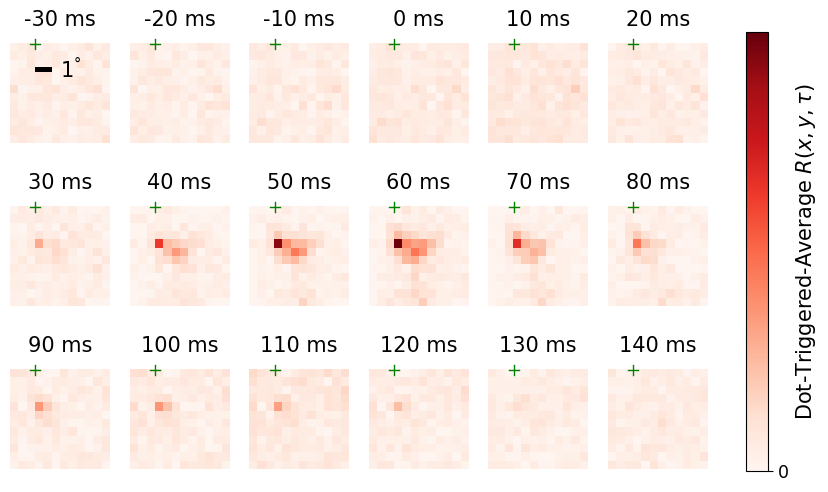

In [5]:
from bisc.dot import save_rf_animation

channel_idx = rng.choice(channel_idxs)
channel_idx = 32
print(f'Channel {channel_idx}')

rf_data = rfs[channel_idx]
vlim = np.abs(rf_data).max()
fig, axes = plot_rf_snapshots(
    rf_data[30:391], xs, ys, taus[30:391], vmin=0, vmax=vlim, cmap='Reds',
    subplots_kwargs={'nrows': 3, 'ncols': 6, 'figsize': (10, 6)},
)
cbar = fig.get_children()[-1]
cbar.set_ylabel(r'Dot-Triggered-Average $R(x, y, \tau)$')
cbar.set_yticks([0])
# fig.savefig(FIG_PATH/'{}_c{:03d}_[{:g}Hz].svg'.format(session_id, channel_idx, transform['freq']))

plt.show()

# All channels as an array

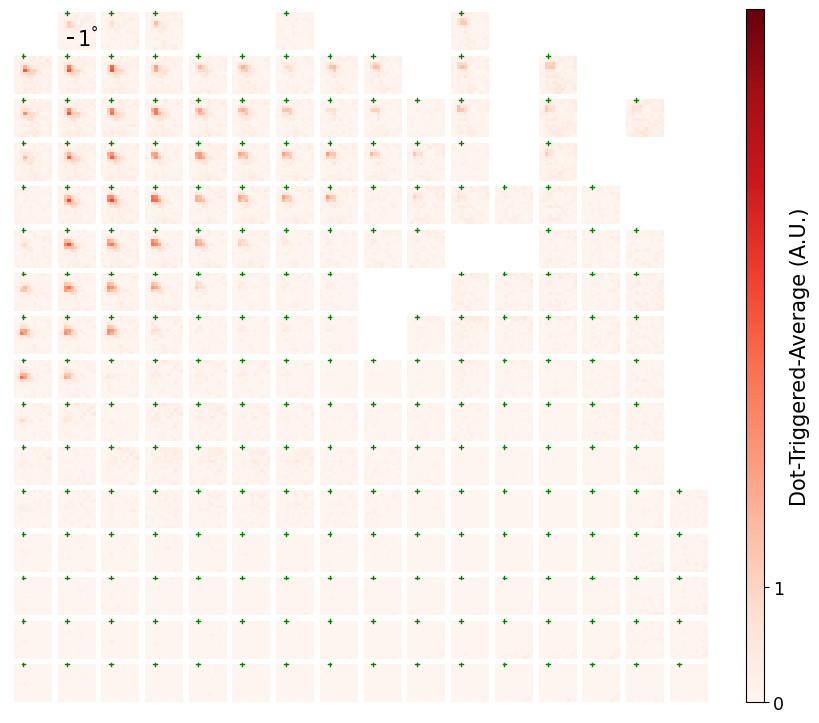

In [6]:
from bisc.dot import plot_rf_heatmap, plot_scale_bar

rfs_s = rfs[:, 250]
if transform['type']=='remove_mean':
    vlim = np.nanmax(np.abs(rfs), axis=(1, 2, 3))
else:
    vlim = np.nanmax(np.abs(rfs)[channel_idxs])

fig, axes = plt.subplots(16, 16, figsize=(10, 9), gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
for i, ax in enumerate(axes.ravel()):
    if i in channel_idxs:
        if transform['type']=='remove_mean':
            h = plot_rf_heatmap(ax, rfs_s[i], xs, ys, vmin=-vlim[i], vmax=vlim[i], cmap='coolwarm')
        else:
            h = plot_rf_heatmap(ax, rfs_s[i], xs, ys, vmin=0, vmax=vlim, cmap='Reds')
    else:
        ax.axis('off')
plot_scale_bar(axes[0, 1], width=0.3, y_offset=4)
cbar = fig.colorbar(h, ax=axes, fraction=0.05, aspect=40, ticks=[0, 1], label='Dot-Triggered-Average (A.U.)')
# fig.savefig(FIG_PATH/'spatial.rf.array_{}_[{:g}Hz].svg'.format(session_id, transform['freq']))
# fig.savefig(FIG_PATH/'rf.array.snapshot_{}_[75ms]_[{:g}Hz].svg'.format(session_id, transform['freq']))
# fig.savefig(FIG_PATH/'rf.array.snapshot_{}_[75ms].svg'.format(session_id))

plt.show()

# Fit Gaussian

In [7]:
from bisc.dot import gauss_2d
from scipy.optimize import minimize

def fit_gauss_2d(rf_s, xs, ys, sigma_lim=(0.1, 1.5), num_optims=200):
    _ys, _xs = np.meshgrid(ys, xs, indexing='ij')
    vlim = np.abs(rf_s).max()
    func = lambda param: gauss_2d(_xs, _ys, *param)
    bounds = (
        (0, 3*vlim), (-2, 4), (-1, 5), sigma_lim, (-vlim, vlim),
    )

    min_loss, param = float('inf'), None
    for _ in range(num_optims):
        res = minimize(lambda param: ((func(param)-rf_s)**2).mean(),
            [rng.uniform(l, h) for l, h in bounds], bounds=bounds,
        )
        if res.fun<min_loss:
            min_loss = res.fun
            param = res.x
    rf_fit = func(param)
    return rf_fit, param

rfs_s = rfs.mean(axis=1)
params_s = np.full((256, 5), fill_value=np.nan)
fvus = np.full((256,), fill_value=np.nan)
for channel_idx in tqdm(channel_idxs, unit='channel'):
    rf_s = rfs_s[channel_idx]
    rf_fit, params_s[channel_idx] = fit_gauss_2d(rf_s, xs, ys)
    fvus[channel_idx] = ((rf_fit-rf_s)**2).mean()/rf_s.var()

  0%|                                                                                                         …

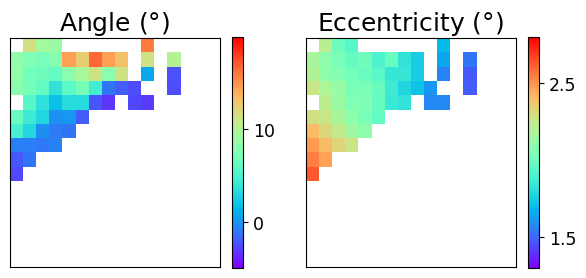

In [8]:
mask = fvus<0.8
x = params_s[:, 1]
y = params_s[:, 2]
angs = np.arctan2(x, y)/np.pi*180
eccs = (x**2+y**2)**0.5

fig, axes = plt.subplots(1, 2, figsize=(7, 3))
for i, ax in enumerate(axes):
    if i==0:
        vals = angs.copy()
        vmin, vmax = -5, 20
        ticks = [0, 10]
        # vmin, vmax = -5, 30
        # ticks = [0, 10, 20]
        title = 'Angle'
    if i==1:
        vals = eccs.copy()
        vmin, vmax = 1.3, 2.8
        # vmin, vmax = 1.5, 3
        ticks = [1.5, 2.5]
        title = 'Eccentricity'
    vals[~mask] = np.nan
    # vmin, vmax = None, None
    h = ax.imshow(vals.reshape(16, 16), extent=[0, 6.8, 0, 7.4], vmin=vmin, vmax=vmax, cmap='rainbow')
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title+r' ($\degree$)')
    for sp in ax.spines.values():
        sp.set_visible(True)
    plt.colorbar(
        h, ax=ax, ticks=ticks, fraction=0.1
    )
# fig.savefig(FIG_PATH/'rfs.center.full.chip_{}_[{:g}Hz].svg'.format(session_id, transform['freq']))

plt.show()

In [9]:
xs = np.arange(16)/16*6.8
ys = np.arange(16)/16*7.4
ys, xs = np.meshgrid(ys, xs, indexing='ij')
torch.save({
    'xs': xs.reshape(-1)[mask], 'ys': ys.reshape(-1)[mask],
    'angs': angs[mask], 'eccs': eccs[mask],
}, '../cache/rfs.center_{}_[{:g}Hz].pt'.format(session_id, transform['freq']))

print('RF centers saved for cortical scaling analysis.')

RF centers saved for cortical scaling analysis.
